# TP2


## Integrantes
* Hagata, Juan Pablo
* Sossa, Fabian
* Yélamos, Fausto Juárez

## Objetivo

### Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan lascámaras digitales modernas. El video a procesar será: “focus_video.mov”.

### 1. Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper "Image Sharpness Measure for Blurred Images in Frequency Domain“ y realizar tres experimentos:
1. Medición sobre todo el frame.
2. Medición sobre una ROI ubicada en el centro del frame. Areade la ROI = 5 o 10% del areatotal del frame.
3. Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores arbitrarios, probar con varios valores 3x3, 7x5, etc… (al menos 3)

### Para cada experimento se debe presentar:
- Una curva o varias curvas que muestren la evolución de la métrica framea framedonde se vea claramente cuando el algoritmo detecto el punto de máximo enfoque.
- Video con la ROI o matriz, graficada en rojo y superpuesta al video original para los framesque no están en foco y verde para los frames donde se detecta la condición de máximo enfoque.

### 2. Cambiar la métrica de enfoque eligiendo uno de los algoritmos explicados en el apéndice de: Analysis of focus measure operators in shapefrom focus.

### El algoritmo de detección a implementar debe detectar y devolver los puntos de máximo enfoque de manera automática.


## 1. Implementación del algoritmo

### Imports y carga de archivos

In [1]:
#%pip install asttokens==2.4.1 certifi==2024.8.30 charset-normalizer==3.3.2 comm==0.2.2 contourpy==1.3.0 cycler==0.12.1 debugpy==1.8.6 decorator==5.1.1 exceptiongroup==1.2.2 executing==2.1.0 fonttools==4.54.1 idna==3.10 ipykernel==6.29.5 ipython==8.28.0 jedi==0.19.1 jupyter_client==8.6.3 jupyter_core==5.7.2 kiwisolver==1.4.7 matplotlib==3.9.2 matplotlib-inline==0.1.7 nest-asyncio==1.6.0 numpy==2.1.2 opencv-python==4.10.0.84 packaging==24.1 parso==0.8.4 pexpect==4.9.0 pillow==10.4.0 platformdirs==4.3.6 prompt_toolkit==3.0.48 psutil==6.0.0 ptyprocess==0.7.0 pure_eval==0.2.3 Pygments==2.18.0 pyparsing==3.1.4 python-dateutil==2.9.0.post0 pyzmq==26.2.0 requests==2.32.3 six==1.16.0 stack-data==0.6.3 tornado==6.4.1 traitlets==5.14.3 typing_extensions==4.12.2 urllib3==2.2.3 wcwidth==0.2.13

In [2]:
import cv2
import os
import requests
import tempfile
import numpy as np
import matplotlib.pyplot as plt

In [3]:
focus_video_url = 'https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/vision_computadora_I/raw/refs/heads/16-cohorte/Material_TPs/TP2/focus_video.mov'

In [4]:
def load_video(video_path):
    # Generar un nombre de archivo temporal
    temp_file_path = os.path.join(tempfile.gettempdir(), 'video_temp.mp4')

    # Verificar si el archivo temporal ya existe
    if os.path.exists(temp_file_path):
        print("Archivo temporal ya existe. Cargando el video...")
    else:
        # Hacer una solicitud GET a la URL
        response = requests.get(video_path)

        # Verificar que la solicitud fue exitosa
        if response.status_code == 200:
            # Crear y escribir en el archivo temporal
            with open(temp_file_path, 'wb') as temp_file:
                temp_file.write(response.content)
        else:
            print("Error al descargar el video.")
            return None

    # Abrir el video usando OpenCV
    cap = cv2.VideoCapture(temp_file_path)

    # Verificar si el video se ha abierto correctamente
    if not cap.isOpened():
        print("Error al abrir el video.")
        return None

    return cap


### Funciones de interés


In [5]:
def calculate_focus_metric(image):
    """ Calcula la métrica de enfoque basada en alta frecuencia en el dominio de Fourier """

    # Cargamos la imagen en escala de grises
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Transformada Rápida de Fourier
    f = np.fft.fft2(gray)

    # Shift para centrar la FFT
    fshift = np.fft.fftshift(f)

    # Valor absoluto del espectro
    magnitude_spectrum = np.abs(fshift)

    # Maximo valor de magnitud
    M = np.max(magnitude_spectrum)

    # Umbral basado en el valor máximo para detectar frecuencias altas
    threshold = M / 1000

    # Cuenta de valores mayores que el umbral (componentes de alta frecuencia)
    high_freq_count = np.sum(magnitude_spectrum > threshold)

    return high_freq_count

def get_center_roi(image, percentage):
    """ Extrae una región central de la imagen que ocupa un porcentaje dado del área total """

    # Dimensiones: altura (h), anchura (w), canales (_)
    h, w, _ = image.shape

    # Tamaño del ROI dado por la raiz cuadrada del porcentaje del area total
    roi_size = int(np.sqrt(percentage / 100) * min(h, w))

    # Posicion de inicio para el ROI en el eje x
    x_start = (w - roi_size) // 2

    # Posicion de inicio para el ROI en el eje y
    y_start = (h - roi_size) // 2

    # Extraccion de la ROI
    return image[y_start:y_start + roi_size, x_start:x_start + roi_size]

def get_grid_regions(image, N, M):
    """ Divide la imagen en una cuadrícula de N filas y M columnas, devuelve cada región """

    # Dimensiones: altura (h), anchura (w), canales (_)
    h, w, _ = image.shape

    # Altura de cada celda en la grilla
    grid_h = h // N

    # Ancho de cada celda en la grilla
    grid_w = w // M

    regions = []

    # Iteracion sobre las filas
    for i in range(N):
        # Iteracion sobre las columnas
        for j in range(M):

            # Posicion de inicio en el eje x
            x_start = j * grid_w

            # Posicion de inicio en el eje y
            y_start = i * grid_h

            # Region de la imagen usando las coordenadas calculadas
            region = image[y_start:y_start + grid_h, x_start:x_start + grid_w]

            regions.append(region)

    return regions

### Desarrollo del algoritmo

In [6]:
# Cargar el video
cap = load_video(focus_video_url)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Frames totales: {frame_count}.")

# Configuracion para los experimentos
roi_percentage = 5  # Porcentaje del area total para la ROI central
grid_sizes = [(3, 3), (7, 5)]  # Tamaños de matrices para la cuadricula NxM


Archivo temporal ya existe. Cargando el video...
Frames totales: 171.


In [7]:
# Mostrar ROI y matriz en el video

def draw_grid(frame, N, M, in_focus_matrix):
    h, w, _ = frame.shape
    grid_h = h // N
    grid_w = w // M
    # Imprimo primero los rojos
    for i in range(N):
        for j in range(M):
            x_start = j * grid_w
            y_start = i * grid_h
            color = (0, 0, 255)
            if not in_focus_matrix[i, j]: cv2.rectangle(frame, (x_start, y_start), (x_start+grid_w, y_start+grid_h), color, 2)

    # Imprimo los verdes por separado para no sobrescribir los bordes
    for i in range(N):
        for j in range(M):
            x_start = j * grid_w
            y_start = i * grid_h
            color = (0, 255, 0) 
            if in_focus_matrix[i, j]: cv2.rectangle(frame, (x_start, y_start), (x_start+grid_w, y_start+grid_h), color, 2)


In [8]:
# Almacenar las metricas
metrics_full_frame = []
metrics_roi = []
metrics_grid = {grid: [] for grid in grid_sizes}

while cap.isOpened():
    ret, frame = cap.read()
    if not ret: break

    # --- Experimento 1: Métrica para todo el frame ---
    metric_full = calculate_focus_metric(frame)
    metrics_full_frame.append(metric_full)

    # --- Experimento 2: Métrica para una ROI central ---
    roi_image = get_center_roi(frame, roi_percentage)
    roi_metric = calculate_focus_metric(roi_image)
    metrics_roi.append(roi_metric)

    # --- Experimento 3: Métrica para una matriz NxM ---
    for grid in grid_sizes:
        N, M = grid
        regions = get_grid_regions(frame, N, M)
        avg_metric_grid = np.mean([calculate_focus_metric(region) for region in regions])
        metrics_grid[grid].append(avg_metric_grid)

print(metrics_roi)

cap.release()

cv2.destroyAllWindows()

[np.int64(635), np.int64(625), np.int64(648), np.int64(640), np.int64(624), np.int64(600), np.int64(604), np.int64(600), np.int64(598), np.int64(606), np.int64(614), np.int64(596), np.int64(606), np.int64(624), np.int64(636), np.int64(632), np.int64(628), np.int64(628), np.int64(632), np.int64(623), np.int64(638), np.int64(621), np.int64(624), np.int64(606), np.int64(604), np.int64(622), np.int64(638), np.int64(624), np.int64(628), np.int64(618), np.int64(624), np.int64(630), np.int64(631), np.int64(639), np.int64(637), np.int64(627), np.int64(619), np.int64(629), np.int64(627), np.int64(627), np.int64(635), np.int64(669), np.int64(641), np.int64(663), np.int64(645), np.int64(669), np.int64(683), np.int64(673), np.int64(691), np.int64(707), np.int64(725), np.int64(703), np.int64(741), np.int64(771), np.int64(787), np.int64(807), np.int64(843), np.int64(891), np.int64(931), np.int64(973), np.int64(1043), np.int64(1117), np.int64(1179), np.int64(1205), np.int64(1259), np.int64(1285), np.

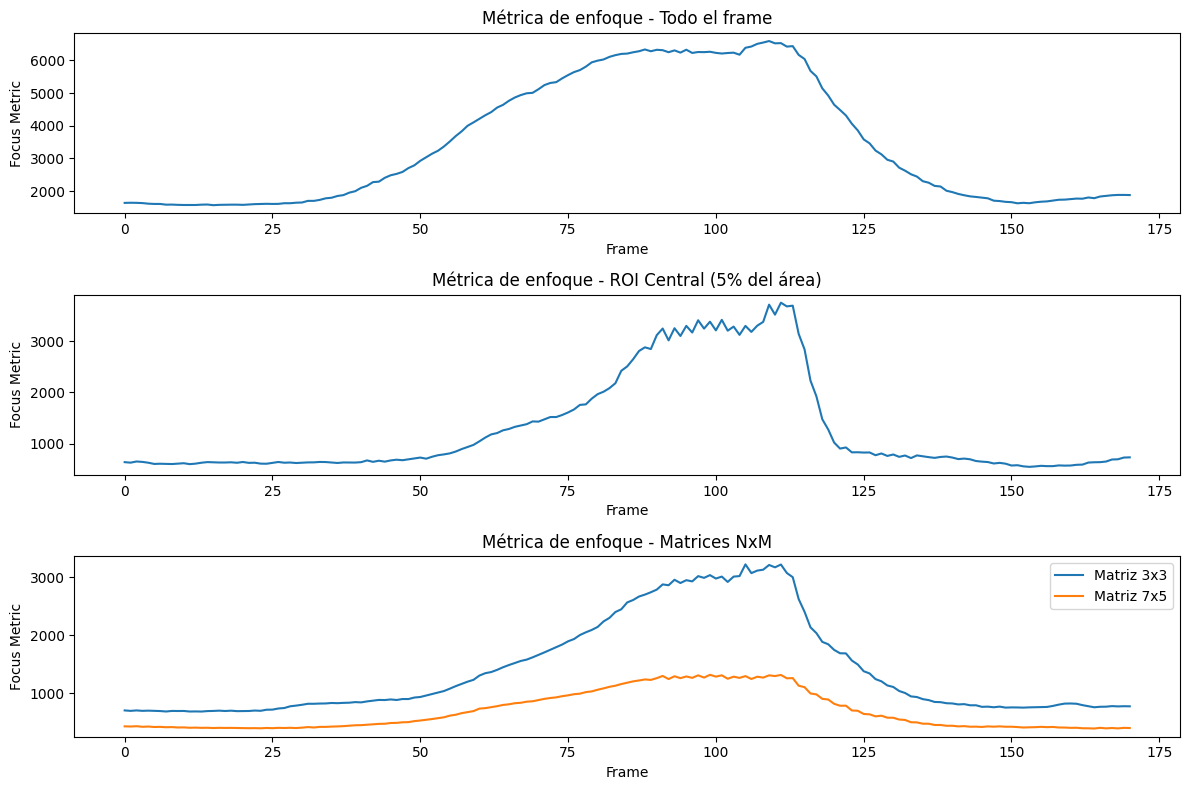

In [9]:
# Graficar la evolucion de las metricas
plt.figure(figsize=(12, 8))

# Métrica para todo el frame
plt.subplot(3, 1, 1)
plt.plot(metrics_full_frame, label="Full Frame")
plt.title('Métrica de enfoque - Todo el frame')
plt.xlabel('Frame')
plt.ylabel('Focus Metric')

# Métrica para la ROI
plt.subplot(3, 1, 2)
plt.plot(metrics_roi, label=f"ROI {roi_percentage}%")
plt.title(f'Métrica de enfoque - ROI Central ({roi_percentage}% del área)')
plt.xlabel('Frame')
plt.ylabel('Focus Metric')

# Métrica para la matriz NxM
for grid in grid_sizes:
    plt.subplot(3, 1, 3)
    plt.plot(metrics_grid[grid], label=f"Matriz {grid[0]}x{grid[1]}")
    plt.title('Métrica de enfoque - Matrices NxM')
    plt.xlabel('Frame')
    plt.ylabel('Focus Metric')
    plt.legend()

plt.tight_layout()
plt.show()

In [10]:
# Mostramos el video superpuesto a las ROI de la grilla

#laplacian_threshold = 2000  # Umbral de enfoque para el Laplaciano (ajustable)
laplacian_threshold = 1500  # Umbral de enfoque para el Laplaciano (ajustable)

for (N, M) in grid_sizes:

    cap = load_video(focus_video_url)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret: break
        # --- Dibujar ROI y matriz en el frame ---

        roi_image = get_center_roi(frame, roi_percentage)
        h, w, _ = frame.shape

        roi = (w//2 - roi_image.shape[1]//2, h//2 - roi_image.shape[0]//2, roi_image.shape[1], roi_image.shape[0])
        
        regions = get_grid_regions(frame, N, M)

        in_focus_matrix = np.array([calculate_focus_metric(region) > laplacian_threshold for region in regions]).reshape(N, M)
        
        draw_grid(frame, N, M, in_focus_matrix)

        # Mostrar frame con visualización de la ROI y las regiones de la matriz
        cv2.imshow('Frame', frame)
        
        # Delay de 20ms (sino no se ve nada)
        if cv2.waitKey(20) & 0xFF == ord('q'): break

    cap.release()
    cv2.destroyAllWindows()


Archivo temporal ya existe. Cargando el video...
Archivo temporal ya existe. Cargando el video...


## 2. Cambio de métrica

In [11]:
def focus_measure(image):
    """Brenner's focus measure (MIS2)"""
    """ Calcula la métrica de enfoque basada en la segunda diferencia de los niveles de gris """

    # Convertimos la imagen a escala de grises
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Computamos la diferencia segunda horizontal
    diff_horiz = np.abs(gray[:, :-2] - gray[:, 2:]) ** 2

    # Computamos la diferencia segunda vertical
    diff_vert = np.abs(gray[:-2, :] - gray[2:, :]) ** 2

    # Combinamos las diferencias y calculamos la suma total
    focus_value = np.sum(diff_horiz) + np.sum(diff_vert)

    return focus_value
    

In [12]:
def process_video(video_path, grid_size=(7, 7), focus_threshold=100):
    N, M = grid_size

    cap = load_video(video_path)
    sharpness_values = []
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret: break
        
        frame_count += 1

        regions = get_grid_regions(frame, N, M)

        max_focus_value = max(focus_measure(region) for region in regions)
        sharpness_values.append(max_focus_value)

        in_focus_matrix = np.array([focus_measure(region) > focus_threshold for region in regions]).reshape(N, M)

        draw_grid(frame, N, M, in_focus_matrix)

        # Mostrar el frame
        cv2.imshow('Focus Matrix', frame)

        if cv2.waitKey(20) & 0xFF == ord('q'): break

    cap.release()
    cv2.destroyAllWindows()

    return sharpness_values, frame_count

Archivo temporal ya existe. Cargando el video...


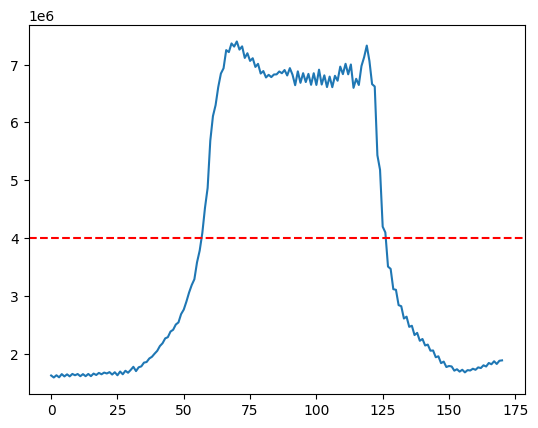

In [13]:
# 1. Medición sobre todo el frame
focus_threshold=4e6

sharpness_values_full_frame, frame_count = process_video(focus_video_url, grid_size=(1, 1), focus_threshold=focus_threshold)

plt.figure()
plt.plot(sharpness_values_full_frame)
plt.axhline(y=focus_threshold, color='r', linestyle='--')
plt.show()


Archivo temporal ya existe. Cargando el video...


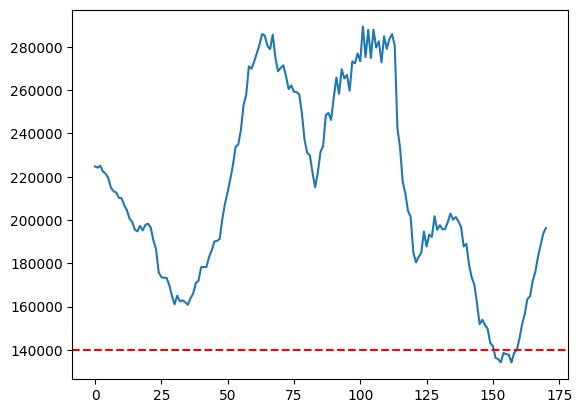

In [14]:
# 2. Medición sobre ROI en el centro del frame (10% del área total)
focus_threshold=140e3

sharpness_values_roi, _ = process_video(focus_video_url, grid_size=(10, 10), focus_threshold=focus_threshold)

plt.figure()
plt.plot(sharpness_values_roi)
plt.axhline(y=focus_threshold, color='r', linestyle='--')
plt.show()


Archivo temporal ya existe. Cargando el video...


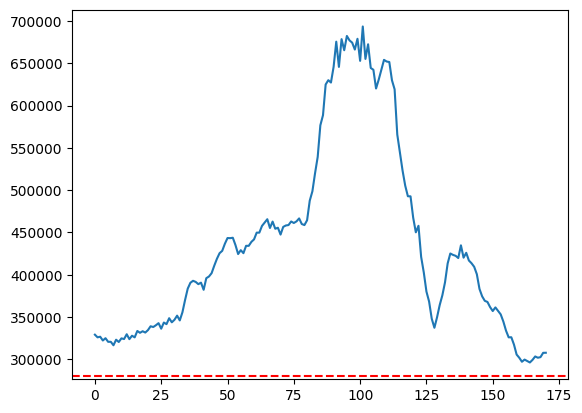

In [15]:
# 3. Medición sobre una matriz de NxM (ej. 7x5)
focus_threshold=280e3

sharpness_values_matrix, _ = process_video(focus_video_url, grid_size=(7, 5), focus_threshold=focus_threshold)

plt.figure()
plt.plot(sharpness_values_matrix)
plt.axhline(y=focus_threshold, color='r', linestyle='--')
plt.show()


In [16]:
# Función para graficar la métrica de enfoque a lo largo de los frames
def plot_sharpness_evolution(sharpness_values, frame_count):
    frames = list(range(frame_count))
    plt.plot(frames, sharpness_values, 'bo-')
    plt.xlabel('Frame #')
    plt.ylabel('Image Sharpness Measure (ISM)')
    plt.title('Evolución del enfoque en el video')
    plt.show()


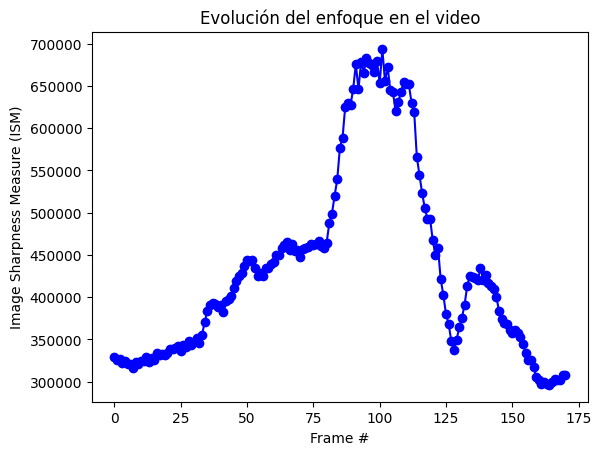

In [17]:
# Graficamos los resultados
plot_sharpness_evolution(sharpness_values_matrix, frame_count)
